In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PTAfast.residuals import copy_array
from PTAfast.correlated_noises import (add_common_correlated_noise, \
                                       add_kinematic_dipole, compute_rotation_matrices, \
                                       gammaI00, gammaV11)

from PTAfast.pulsar_fft import pta_fft
from PTAfast.spectrum import powerlaw

# theoretical modelling
from PTAfast.transfer_functions import TF_Alpha, TF_Beta, TF_AlphaBeta
from PTAfast.ensemble_variances import xy_gaussian_ev_master

# easy simulations
import pickle
from PTAfast.make_sims import *
from PTAfast.pulsar_stats import *
from PTAfast.pulsar_class import *

We show how to use the `PTAfast.residuals` to obtain time-of-arrival simulations (prefit residuals). This is mostly based on `fakepta` (huge credits!) with `PTAfast` modifications mainly on the GWB simulation procedure. See [arXiv:2507.15756](https://arxiv.org/abs/2507.15756).

Note that `fakepta` does post-fit residuals.

## 1. Simulating pulsars

We simulate pulsars analogous to `fakepta`'s `make_fake_array`; using `make_ideal_array` as (e.g., 10 pulsars, 15-year observations, 100 Time-of-Arrivals)

In [2]:
psrs = make_ideal_array(npsrs=10, Tobs=15, ntoas=100, isotropic=True, gaps=True, toaerr=1e-7, xz_pulsars=False)

Creating psr J0724+6416
Creating psr J2214+4443
Creating psr J1304+3000
Creating psr J0354+1746
Creating psr J1844+0574
Creating psr J0934-0574
Creating psr J0024-1746
Creating psr J1514-3000
Creating psr J0604-4443
Creating psr J2054-6416
Setup ideal PTA 15-yr data with 10 pulsars


If `save_pickle=True` a pickle file will be saved in a directory `./sims`. The file name can be specified via `pkl_file='my_ideal_pta'`. The simulated PTA can be loaded directly or easily using `load_gauss_array`.

The pulsars' positions can be viewed as follows;

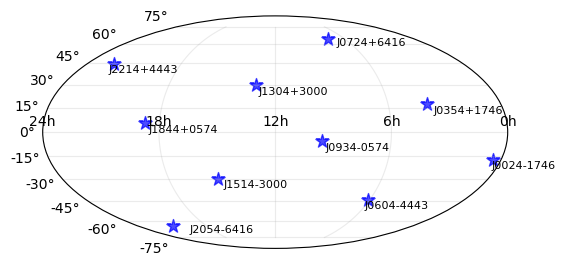

In [3]:
marker='*'; color='blue'; alpha=0.7; plot_name=True
plt.figure(figsize=(6, 6))
ax = plt.axes(projection='mollweide')
ax.grid(True, **{'alpha':0.25})
plt.xticks(np.pi - np.linspace(0., 2*np.pi, 5), ['0h', '6h', '12h', '18h', '24h'], fontsize=10)
plt.yticks(fontsize=10)
for psr in psrs:
    ax.scatter(np.pi - np.array(psr.phi), np.pi/2 - np.array(psr.theta), \
                marker=marker, s=100, alpha=alpha, color=color)
    if plot_name:
        ax.annotate(psr.name, (np.pi - psr.phi + 0.05, np.pi/2 - psr.theta - 0.1), color='k', fontsize=8)
plt.show()

The isotropic setting of `make_ideal_array` can be changed to `isotropic=False` for a more realistic distribution. The rest of the settings are the same as in `fakepta` except for two additions: an option `xz_pulsars=True` (to create pulsars on the xz plane) and a new pulsar attribute `residuals_gauss` where the new modified pulsar timing residuals (simulated according to [arXiv:2507.15756](https://arxiv.org/abs/2507.15756)) are stored.

The `xz_pulsars` option was created for computational frame and circular polarization related tests.

We can check that the ToAs (in either `psr.residuals` or `psr.residuals_gauss`) are trivial;

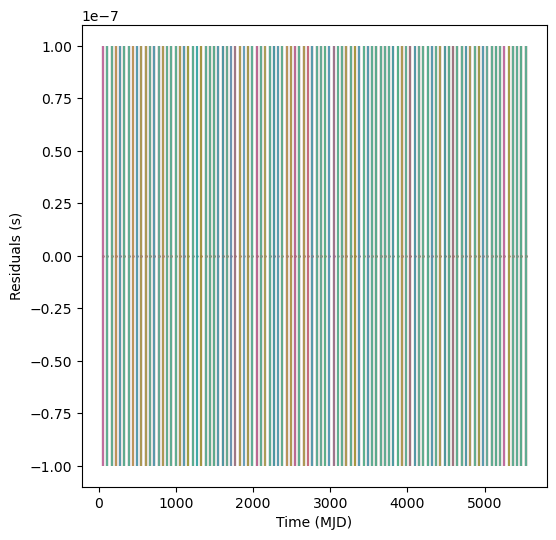

In [4]:
fig, ax= plt.subplots(figsize=(6, 6))
for psr in psrs:
    ax.errorbar(psr.toas/86400, psr.residuals_gauss, yerr=psr.toaerrs, fmt='.', markersize=1, alpha=0.5)
ax.set_xlabel('Time (MJD)'); ax.set_ylabel('Residuals (s)')
plt.show()

Now let's simulate a GWB signal; differentiating results when transfer functions are considered and when they are not. For this purpose, let's also simulate a noise dictionary (for red and white noises);

In [5]:
# a noise dictionary for the simulated pulsars
noisedict=make_noise_dict(psrs, save_pickle=False)

# creates pulsar objects consistent with psrs and but with noise parameters according to noisedict
psrs_copy=copy_array(psrs, noisedict)

To add a GWB signal we do

In [6]:
add_common_correlated_noise(psrs_copy, orf='hd', spectrum='powerlaw', log10_A=-15, gamma=13/3)

Note that the PTA object of interest is now `psrs_copy` since this is consistent with `noisedict`.

Let's look at three representative pulsars (chosen randomly);

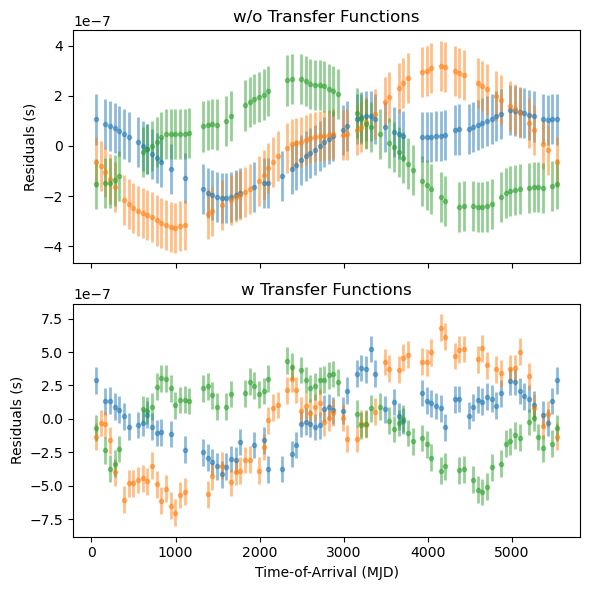

In [7]:
fig, ax = plt.subplots(figsize=(6, 6), nrows=2, sharex=True)
res_std=[]; res_gauss_std=[]
line_styles = ['-', '--', '-.']
idxs=[]
for i, style in enumerate(line_styles):
    idx = np.random.randint(0, len(psrs_copy) - 1)
    idxs.append(idx)
    psr = psrs_copy[idx]
    res_std.append(np.std(psr.residuals)); res_gauss_std.append(np.std(psr.residuals_gauss))
    
    interval=1
    ax[0].errorbar(psr.toas[::interval]/86400, psr.residuals[::interval], \
                   yerr=psr.toaerrs[::interval], fmt='.', alpha=0.5, lw=2)
    ax[1].errorbar(psr.toas[::interval]/86400, psr.residuals_gauss[::interval], \
                   yerr=psr.toaerrs[::interval], fmt='.', alpha=0.5, lw=2)

ax[0].set_title(rf'w/o Transfer Functions')
ax[1].set_title(rf'w Transfer Functions')

ax[1].set_xlabel('Time-of-Arrival (MJD)')
ax[0].set_ylabel('Residuals (s)'); ax[1].set_ylabel('Residuals (s)')

fig.tight_layout(); plt.show()

We can include white noise as follows;

In [8]:
for psr in psrs_copy:
    psr.add_white_noise()

Then, the same residuals would look like

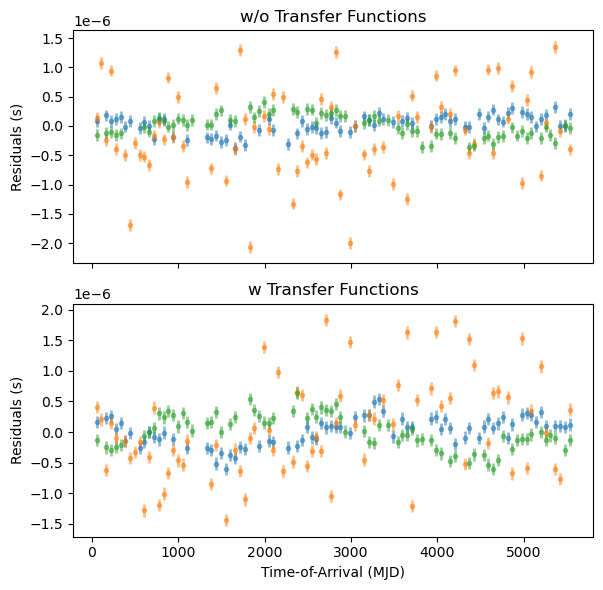

In [9]:
fig, ax = plt.subplots(figsize=(6, 6), nrows=2, sharex=True)
res_std=[]; res_gauss_std=[]
line_styles = ['-', '--', '-.']
for i, style in enumerate(line_styles):
    idx = idxs[i]
    psr = psrs_copy[idx]
    res_std.append(np.std(psr.residuals)); res_gauss_std.append(np.std(psr.residuals_gauss))
    
    interval=1
    ax[0].errorbar(psr.toas[::interval]/86400, psr.residuals[::interval], \
                   yerr=psr.toaerrs[::interval], fmt='.', alpha=0.5, lw=2)
    ax[1].errorbar(psr.toas[::interval]/86400, psr.residuals_gauss[::interval], \
                   yerr=psr.toaerrs[::interval], fmt='.', alpha=0.5, lw=2)

ax[0].set_title(rf'w/o Transfer Functions')
ax[1].set_title(rf'w Transfer Functions')

ax[1].set_xlabel('Time-of-Arrival (MJD)')
ax[0].set_ylabel('Residuals (s)'); ax[1].set_ylabel('Residuals (s)')

fig.tight_layout(); plt.show()

Red noises can also be included (simulated as in `fakepta`) as follows;

``` python
for psr in psrs_copy:
    psr_noisedict=psr.noisedict
    log10_A_key = next(k for k in psr_noisedict if k.endswith('log10_RN_Amp'))
    gamma_key = next(k for k in psr_noisedict if k.endswith('RN_gamma'))
    psr.add_red_noise(log10_A=psr_noisedict[log10_A_key], gamma=psr_noisedict[gamma_key])
```

These are intrinsic correlated process attributed to pulsar spin irregularities.

## 2. Theoretical modelling of the GWB signal

We proceed to the theoretical modelling of the signal (unpolarized). To this end, let's simulate a 15-year PTA with 25 pulsars each with 10000 ToAs;

Creating psr J0724+7374
Creating psr J2214+6164
Creating psr J1304+5313
Creating psr J0354+4605
Creating psr J1844+3979
Creating psr J0934+3406
Creating psr J0024+2869
Creating psr J1514+2358
Creating psr J0604+1866
Creating psr J2054+1389
Creating psr J1144+0921
Creating psr J0234+0459
Creating psr J1724+0000
Creating psr J0814-0459
Creating psr J2304-0921
Creating psr J1354-1389
Creating psr J0444-1866
Creating psr J1934-2358
Creating psr J1024-2869
Creating psr J0114-3406
Creating psr J1604-3979
Creating psr J0654-4605
Creating psr J2144-5313
Creating psr J1234-6164
Creating psr J0324-7374
Setup ideal PTA 15-yr data with 25 pulsars


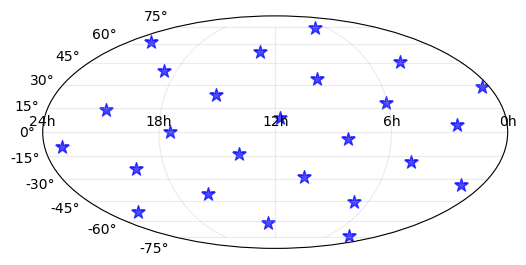

In [10]:
psrs = make_ideal_array(npsrs=25, Tobs=15, ntoas=10000, isotropic=True, \
                        gaps=True, toaerr=1e-7, save_pickle=False)
noisedict=make_noise_dict(psrs, save_pickle=False)
psrs_copy=copy_array(psrs, noisedict)


# plot pulsars on a Mollweide projection
marker='*'; color='blue'; alpha=0.7; plot_name=False
plt.figure(figsize=(6, 6))
ax = plt.axes(projection='mollweide')
ax.grid(True, **{'alpha':0.25})
plt.xticks(np.pi - np.linspace(0., 2*np.pi, 5), ['0h', '6h', '12h', '18h', '24h'], fontsize=10)
plt.yticks(fontsize=10)
for psr in psrs:
    ax.scatter(np.pi - np.array(psr.phi), np.pi/2 - np.array(psr.theta), \
                marker=marker, s=100, alpha=alpha, color=color)
    if plot_name:
        ax.annotate(psr.name, (np.pi - psr.phi + 0.05, np.pi/2 - psr.theta - 0.1), color='k', fontsize=8)
plt.show()

Now let's include a signal, as usual; first on a noise-free setup;

In [11]:
add_common_correlated_noise(psrs_copy, orf='hd', spectrum='powerlaw', log10_A=-15, gamma=13/3)

The function `pta_fft` computes the Fourier coefficients of each pulsar using a standard FFT, then computes sample averages of the squares of Fourier coefficients in the respective frequency bins. This is demonstrated below.

In [12]:
# compute Fourier coefficients of each timing data of each pulsar
freqs_nhz, var_a, var_b, ave_ab=pta_fft(psrs_copy, n_bins=14, res_gauss=True)

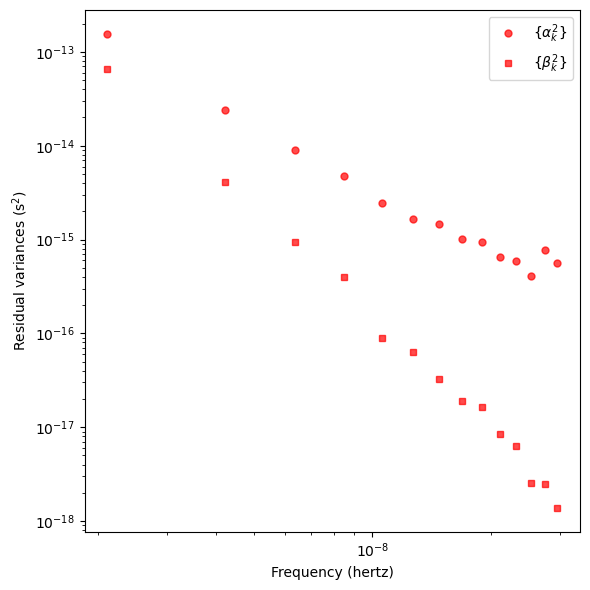

In [13]:
freqs=freqs_nhz*1e-9  # convert to hertz
fig, ax=plt.subplots(figsize=(6,6))
ax.errorbar(freqs, y=var_a, fmt='ro', markersize=5, alpha=0.7, label=r'$\{ \alpha^2_k \}$')
ax.errorbar(freqs, y=var_b, fmt='rs', markersize=5, alpha=0.7, label=r'$\{ \beta^2_k \}$')
ax.set_xlabel('Frequency (hertz)'); ax.set_ylabel(r'Residual variances (s$^2$)')
ax.set_yscale('log'); ax.set_xscale('log'); ax.legend(loc='upper right')
fig.tight_layout(); plt.show()

We can compare these to Gaussian theoretical expectation values (accounting for transfer functions given in [arXiv:2507.15756](https://arxiv.org/abs/2507.15756)). This can be computed using `xy_gaussian_ev_master`, as shown with a powerlaw PSD;

In [14]:
k_gauss, ak2_gauss, bk2_gauss=\
    xy_gaussian_ev_master(S=lambda x: powerlaw(x, log10_A=-15, gamma=13/3), \
                                               fgw_min=1e-9, fgw_max=1e-7, fgw_N=10000, T_yr=15, k_max=14)

The simulated and theoretical variances are shown below;

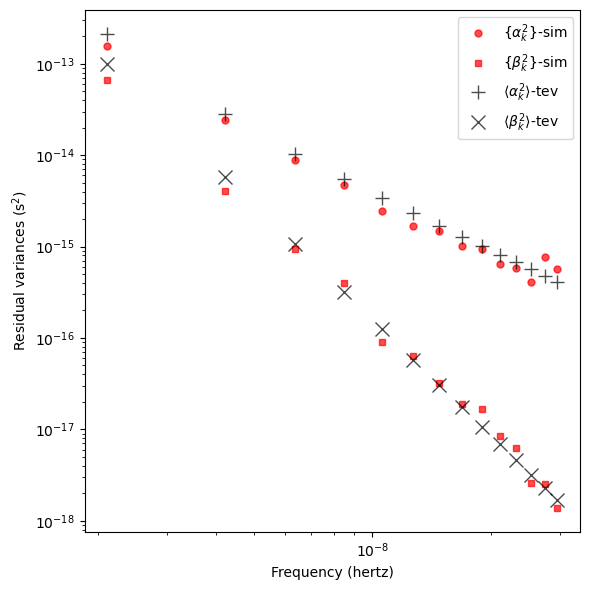

In [15]:
freqs=freqs_nhz*1e-9  # convert to hertz
fig, ax=plt.subplots(figsize=(6,6))
ax.errorbar(freqs, y=var_a, fmt='ro', markersize=5, alpha=0.7, label=r'$\{ \alpha^2_k \}$-sim')
ax.errorbar(freqs, y=var_b, fmt='rs', markersize=5, alpha=0.7, label=r'$\{ \beta^2_k \}$-sim')

# Gaussian theoretical expectation values (tev)
ax.errorbar(k_gauss*freqs[0], ak2_gauss, fmt='k+', \
            alpha=0.7, markersize=10, label=r'$\langle \alpha_k^2 \rangle$-tev')
ax.errorbar(k_gauss*freqs[0], bk2_gauss, fmt='kx', \
            alpha=0.7, markersize=10, label=r'$\langle \beta_k^2 \rangle$-tev')


ax.set_xlabel('Frequency (hertz)'); ax.set_ylabel(r'Residual variances (s$^2$)')
ax.set_yscale('log'); ax.set_xscale('log'); ax.legend(loc='upper right')
fig.tight_layout(); plt.show()

Since this is a noise-free simulation, we can check that the HD isotropic signal is present by just simply binning the Fourier coefficients in angular separations across the whole PTA. The computation of the Fourier coefficients and pulsar-pairing is demonstrated in the following;

In [16]:
psrs_sim=psrs_copy
tmin = [p.toas.min() for p in psrs_sim]; tmax = [p.toas.max() for p in psrs_sim]
Tspan = np.max(tmax) - np.min(tmin); Tspan_yr = np.round(Tspan/86400/365.25, 1)

tmin_mjd = 0; n_bins=14

angles=[]; akak_bin=[]; bkbk_bin=[]; akbk_bin=[]

# computes pulsar pair fourier coefficients; Fourier space covariance matrix
for a, psr_a in enumerate(psrs_sim):
    for b, psr_b in enumerate(psrs_sim):
        if a <= b:
            _, a_psr_a, b_psr_a, _ = \
                get_fft(tmin_mjd + psr_a.toas/86400, psr_a.residuals_gauss, \
                        Tspan_yr=Tspan_yr, n_bins=n_bins) # frequency binning for psr_a
            _, a_psr_b, b_psr_b, _ = \
                get_fft(tmin_mjd + psr_b.toas/86400, psr_b.residuals_gauss, \
                        Tspan_yr=Tspan_yr, n_bins=n_bins) # frequency binning for psr_b

            angle = compute_eaeb(psr_a, psr_b); angles.append(angle)
            akak_bin.append( (a_psr_a*a_psr_b) ); bkbk_bin.append( (b_psr_a*b_psr_b) )
            akbk_bin.append( (a_psr_a*b_psr_b) )

angles= np.array(angles)
akak_bin = np.array(akak_bin); bkbk_bin = np.array(bkbk_bin); akbk_bin = np.array(akbk_bin)

Now, we can make use of the functions below to combine the data in angular bins per each frequency bin labelled by `k_index`;

In [17]:
def calculate_angular_binned_stats_single(data_bin, angles, k_index, na_bins, angle_zero=1e-3):
    # apply angle cutoff to identify zero angular separation/autocorrelation terms
    valid_mask = angles >= angle_zero
    angles_cut = angles[valid_mask]
    data_cut = data_bin[valid_mask, k_index]

    # create angular bin edges and centers
    bin_edges = np.linspace(0, np.pi, na_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    binned_means = np.full(na_bins, np.nan)
    binned_errors = np.full(na_bins, np.nan)

    for i in range(na_bins):
        bin_mask = (angles_cut >= bin_edges[i]) & (angles_cut < bin_edges[i + 1])
        selected_values = data_cut[bin_mask]
        if selected_values.size > 0:
            binned_means[i] = np.mean(selected_values)
            binned_errors[i] = np.std(selected_values) / np.sqrt(len(selected_values))

    return bin_centers, binned_means, binned_errors


def collect_zeroth_bin_stats_single(data_bin, angles, k_index, angle_zero=1e-3):
    # compute the autocorrelation terms
    zero_mask = angles < angle_zero
    zero_values = data_bin[zero_mask, k_index]

    if zero_values.size > 0:
        mean = np.mean(zero_values)
        stderr = np.std(zero_values) / np.sqrt(len(zero_values))
        count = len(zero_values)
    else:
        mean = np.nan
        stderr = np.nan
        count = 0

    return mean, stderr, count

Applying these to the simulated data, we obtain;

In [18]:
na_bins = 10
k_index = 0

akak_centers, akak_binned, akak_error = calculate_angular_binned_stats_single(akak_bin, angles, k_index, na_bins)
bkbk_centers, bkbk_binned, bkbk_error = calculate_angular_binned_stats_single(bkbk_bin, angles, k_index, na_bins)

akak0_mean, akak0_err, _=collect_zeroth_bin_stats_single(akak_bin, angles, k_index)
bkbk0_mean, bkbk0_err, _=collect_zeroth_bin_stats_single(bkbk_bin, angles, k_index)

Then, we find the result shown;

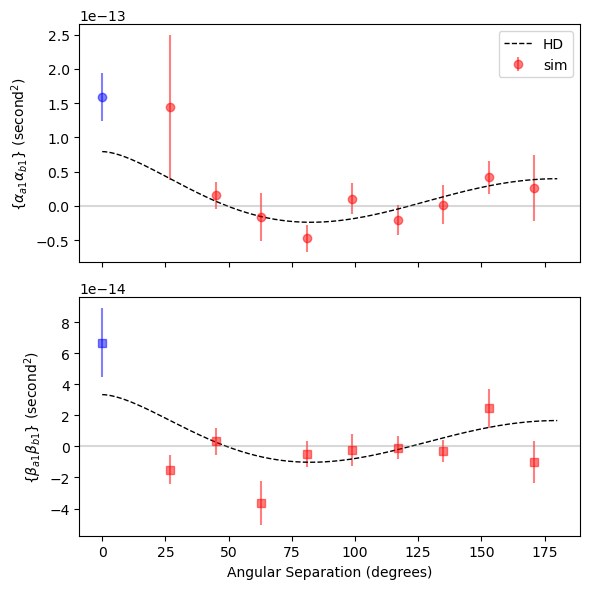

In [19]:
fig, ax=plt.subplots(figsize=(6,6), nrows=2, sharex=True)

k_index=0  # index of the frequency bin to plot
ax[0].errorbar(akak_centers*180/np.pi, y=akak_binned, yerr=akak_error, fmt='ro', alpha=0.5, label=r'sim')
ax[1].errorbar(bkbk_centers*180/np.pi, y=bkbk_binned, yerr=bkbk_error, fmt='rs', alpha=0.5, label=r'sim')

# autocorrelation terms
ax[0].errorbar(0, y=akak0_mean, yerr=akak0_err, fmt='bo', alpha=0.5)
ax[1].errorbar(0, y=bkbk0_mean, yerr=bkbk0_err, fmt='bs', alpha=0.5)

# HD_curve*(1 + delta_ab); normalized to the autocorrelation's value
zeta_space=np.linspace(0, np.pi, 1000); hd_space=C_hd(zeta_space)
ax[0].plot(zeta_space*180/np.pi, hd_space*akak0_mean, 'k--', lw=1, label=r'HD')
ax[1].plot(zeta_space*180/np.pi, hd_space*bkbk0_mean, 'k--', lw=1)

ax[0].set_ylabel(rf'$\{{ \alpha_{{a{k_index+1}}} \alpha_{{b{k_index+1}}} \}}$ (second$^2$)')
ax[1].set_ylabel(rf'$\{{ \beta_{{a{k_index+1}}} \beta_{{b{k_index+1}}} \}}$ (second$^2$)')

ax[1].set_xlabel(r'Angular Separation (degrees)')
ax[0].axhline(y=0, ls='-', color='gray', alpha=0.3)
ax[1].axhline(y=0, ls='-', color='gray', alpha=0.3)
fig.tight_layout(); fig.subplots_adjust(hspace=0.1, wspace=0)

ax[0].legend(loc='upper right')

fig.tight_layout()
plt.show()

This roughly confirms that the signal simulated is consistent with the GWB or a GW signal due to the agreement with the HD curve.

Users are encouraged to play with this methodology with a hundred pulsars (or more!), anisotropic pulsar distributions, and nontrivial noises.

## 3. Circularly polarized SGWB signal

In this section, we show how a circularly polarized SGWB signal can be simulated using PTAfast. We start with the usual (creating pulsars);

In [2]:
psrs = make_ideal_array(npsrs=100, Tobs=15, ntoas=10000, isotropic=True, \
                        gaps=True, toaerr=1e-7, save_pickle=False)
noisedict=make_noise_dict(psrs, save_pickle=False)
psrs_copy=copy_array(psrs, noisedict)

Creating psr J0724+8189
Creating psr J2214+7593
Creating psr J1304+7181
Creating psr J0354+6843
Creating psr J1844+6551
Creating psr J0934+6287
Creating psr J0024+6046
Creating psr J1514+5821
Creating psr J0604+5601
Creating psr J2054+5401
Creating psr J1144+5219
Creating psr J0234+5035
Creating psr J1724+4859
Creating psr J0814+4689
Creating psr J2304+4523
Creating psr J1354+4363
Creating psr J0444+4207
Creating psr J1934+4054
Creating psr J1024+3905
Creating psr J0114+3759
Creating psr J1604+3616
Creating psr J0654+3475
Creating psr J2144+3337
Creating psr J1234+3201
Creating psr J0324+3066
Creating psr J1814+2934
Creating psr J0904+2803
Creating psr J2354+2674
Creating psr J1444+2547
Creating psr J0534+2402
Creating psr J2024+2295
Creating psr J1114+2172
Creating psr J0203+2049
Creating psr J1653+1927
Creating psr J0743+1806
Creating psr J2233+1686
Creating psr J1323+1566
Creating psr J0413+1448
Creating psr J1903+1303
Creating psr J0953+1212
Creating psr J0043+1095
Creating psr J15

Note that we created a hundred pulsars since our method of recovery of an anisotropic circularly polarized signal is not optimal (using only a fraction of the number of pulsar pairs). See the dicussion in [arXiv:2507.15756](https://arxiv.org/abs/2507.15756) related to subtleties in the computational frame.

Consider a GWB and a kinematic dipole with the following parameters;

In [3]:
# GWB and kinematic dipole parameters
log10_A_gw=-15; gamma_gw=13/3

# dipole along the y-direction with speed beta=v/c
# a realistic choice of beta would be beta=1e-3 but the signal is too weak to visualize
v_pos=np.array([0, 1, 0]); beta=1e-1

v00=1 # percentage circularly polarized signal 0 <= v00 <= 1

Now we create multiple PTA simulations all with the same signal input. In each simulation, we compute the Fourier correlation function (Fourier components of the signal covariance matrix) and stack the simulations. The reason many simulations are needed is also due to the non optimal way of measuring the anistrotropic circularly polarized signal in the computational frame.

In [4]:
n_sims = 300; n_bins = 14; tmin_mjd = 0

angles_ensemble = []
akak_ensemble = []; bkbk_ensemble = []; akbk_ensemble = []

for sim in range(n_sims):
    
    for psr in psrs_copy:
        psr.make_ideal()

    # inject kinematic dipole signal
    add_kinematic_dipole(psrs_copy, log10_A=log10_A_gw, gamma=gamma_gw, \
                         v00=v00, beta=beta, v_pos=v_pos)
    

    # recover standard gwb signal + kinematic dipole signal
    # get the minimum and maximum TOAs for all pulsars
    tmin = [p.toas.min() for p in psrs_copy]; tmax = [p.toas.max() for p in psrs_copy]
    Tspan = np.max(tmax) - np.min(tmin); Tspan_yr = np.round(Tspan / 86400 / 365.25, 1)

    angles=[]; akak_bin=[]; bkbk_bin=[]; akbk_bin=[]

    # compute angles between each pair of pulsars to a fixed pulsar a (computational frame)
    a=0 # psr_a_idx
    psr_a=psrs_copy[a]
    # frequency binning for psr_a
    _, a_psr_a, b_psr_a, _ = \
        get_fft(tmin_mjd + psr_a.toas/86400, psr_a.residuals_gauss, \
                Tspan_yr=Tspan_yr, n_bins=n_bins)

    for b, psr_b in enumerate(psrs_copy):
        if b!=a:
            # frequency binning for psr_b
            _, a_psr_b, b_psr_b, _ = \
                get_fft(tmin_mjd + psr_b.toas/86400, psr_b.residuals_gauss, \
                        Tspan_yr=Tspan_yr, n_bins=n_bins)

            angle = compute_eaeb(psr_a, psr_b); angles.append(angle)
            akak_bin.append( (a_psr_a*a_psr_b) ); bkbk_bin.append( (b_psr_a*b_psr_b) )

            # compute dipole direction in the computational frame
            R1, R2 = compute_rotation_matrices(psr_a.pos, psr_b.pos)
            v_pos_cf = R2 @ R1 @ v_pos 
            v_phi=np.arctan2(v_pos_cf[1], v_pos_cf[0])
            v_theta = np.arccos(v_pos_cf[2])

            akbk_bin.append( (a_psr_a*b_psr_b)/(np.sin(v_theta)*np.sin(v_phi)) )


    angles = np.array(angles)
    akak_bin = np.array(akak_bin); bkbk_bin = np.array(bkbk_bin)
    akbk_bin = np.array(akbk_bin)

    angles_ensemble.append(angles)
    akak_ensemble.append(akak_bin); bkbk_ensemble.append(bkbk_bin)
    akbk_ensemble.append(akbk_bin)

angles_ensemble = np.array(angles_ensemble)
akak_ensemble = np.array(akak_ensemble); bkbk_ensemble = np.array(bkbk_ensemble)
akbk_ensemble = np.array(akbk_ensemble)

Now that the ensemble (multiple simulations of the stochastic signal) is available, we use the function below to bin the results in angular separations to view the correlation functions in Fourier space;

In [5]:
def calculate_angular_binned_stats(data_bin, angles_ensemble, k_index, na_bins, angle_zero=1e-3):
    # create angular bin edges from angle_zero to pi
    bin_edges = np.linspace(angle_zero, np.pi, na_bins + 1)
    bin_centers = np.concatenate((
        [angle_zero / 2],                    # center for zeroth bin
        0.5 * (bin_edges[:-1] + bin_edges[1:])  # centers for other bins
    ))

    # initialize output arrays
    binned_means = np.full(na_bins + 1, np.nan)
    binned_errors = np.full(na_bins + 1, np.nan)

    # extract data at frequency index k
    data_k = data_bin[:, :, k_index]  # shape: (n_realizations, n_pairs)

    # flatten everything for easier masking
    flat_data = data_k.flatten()
    flat_angles = angles_ensemble.flatten()

    # zeroth bin: angles < angle_zero
    zero_mask = flat_angles < angle_zero
    zero_values = flat_data[zero_mask]
    if zero_values.size > 0:
        binned_means[0] = np.mean(zero_values)
        binned_errors[0] = np.std(zero_values) / np.sqrt(len(zero_values))

    # loop through other angular bins (starting at bin 1)
    for i in range(na_bins):
        bin_mask = (flat_angles >= bin_edges[i]) & (flat_angles < bin_edges[i+1])
        bin_values = flat_data[bin_mask]

        if bin_values.size > 0:
            binned_means[i+1] = np.mean(bin_values)
            binned_errors[i+1] = np.std(bin_values) / np.sqrt(len(bin_values))

    return bin_centers, binned_means, binned_errors

This is applied to the simulated data as follows;

In [6]:
na_bins = 10
k_index = 0  # choose desired frequency bin

akak_centers, akak_binned, akak_error = calculate_angular_binned_stats(akak_ensemble, angles_ensemble, k_index, na_bins)
bkbk_centers, bkbk_binned, bkbk_error = calculate_angular_binned_stats(bkbk_ensemble, angles_ensemble, k_index, na_bins)
akbk_centers, akbk_binned, akbk_error = calculate_angular_binned_stats(akbk_ensemble, angles_ensemble, k_index, na_bins)

We prepare the theoretical expectation values below (stored as the Fourier components of the correlation in the $k$-th frequency bin);

In [7]:
# Gaussian theoretical expectation values computation

Tspan= 15*365.25*86400  # 15 years in seconds
n_bins=14 # number of frequency bins

# frequency grid specs for computing the Fourier components of the correlation
fgw_min=1e-9; fgw_max=1e-7; fgw_N=10000
logfgws = np.linspace(np.log(fgw_min), np.log(fgw_max), fgw_N); fgws=np.exp(logfgws)
dlogfgws = (np.log(fgw_max) - np.log(fgw_min))/fgw_N; dfgws=fgws*dlogfgws

psd_gwb_gauss = powerlaw(fgws, log10_A=log10_A_gw, gamma=gamma_gw)
ni=-gamma_gw + 2; nv=ni

# covariance matrix components at kth-bin (k_index+1)
var_Alpha = np.sum(dfgws * TF_Alpha(fgws, k_index+1, k_index+1, Tspan) * v00 * psd_gwb_gauss)
var_Beta = np.sum(dfgws * TF_Beta(fgws, k_index+1, k_index+1, Tspan) * v00 * psd_gwb_gauss)
cov_AlphaBeta = np.sum(dfgws * TF_AlphaBeta(fgws, k_index+1, k_index+1, Tspan) * v00 * psd_gwb_gauss)

The results are shown below together with the expected theoretical curves (ORFs for HD and circular polarization);

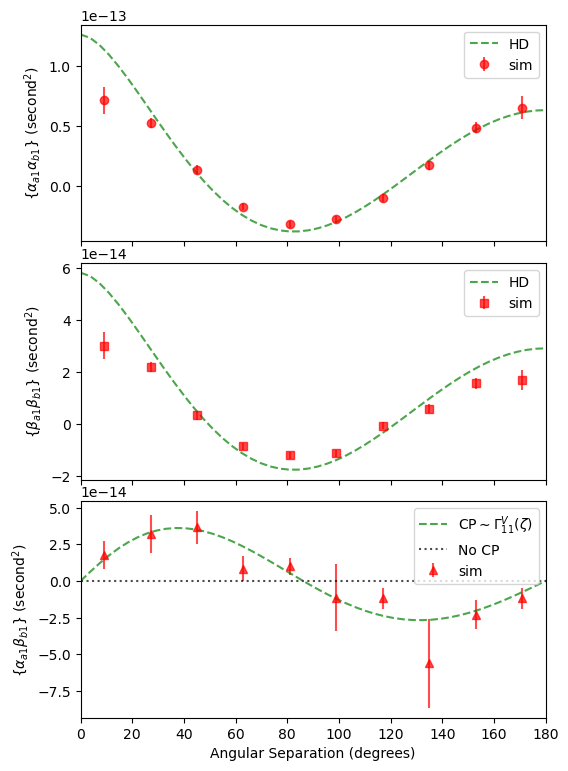

In [8]:
fig, ax = plt.subplots(figsize=(6, 9), nrows=3, sharex=True)

# show two-point correlation functions
ax[0].errorbar(akak_centers * 180 / np.pi, akak_binned, yerr=akak_error, \
                fmt='ro', alpha=0.7, label='sim')
ax[1].errorbar(bkbk_centers * 180 / np.pi, bkbk_binned, yerr=bkbk_error, \
                fmt='rs', alpha=0.7, label='sim')
ax[2].errorbar(akbk_centers * 180 / np.pi, akbk_binned, yerr=akbk_error, \
                fmt='r^', alpha=0.7, label='sim')

ax[0].set_ylabel(rf'$\{{ \alpha_{{a{k_index+1}}} \alpha_{{b{k_index+1}}} \}}$ (second$^2$)')
ax[1].set_ylabel(rf'$\{{ \beta_{{a{k_index+1}}} \beta_{{b{k_index+1}}} \}}$ (second$^2$)')
ax[2].set_ylabel(rf'$\{{ \alpha_{{a{k_index+1}}} \beta_{{b{k_index+1}}} \}}$ (second$^2$)')

xi_space=np.linspace(0, np.pi, 50)
ax[0].plot(xi_space*180/np.pi, gammaI00(xi_space)*var_Alpha/2, 'g--', alpha=0.7, label='HD')
ax[1].plot(xi_space*180/np.pi, gammaI00(xi_space)*var_Beta/2, 'g--', alpha=0.7, label='HD')
ax[2].plot(xi_space*180/np.pi, v00*cov_AlphaBeta*gammaV11(xi_space)*np.sqrt(8*np.pi/3)*beta*(1-nv)/2, \
           'g--', alpha=0.7, label=r'CP$\sim\Gamma_{11}^V(\zeta)$')

ax[2].axhline(y=0, color='k', linestyle=':', alpha=0.7, label=r'No CP')
ax[2].set_xlabel(r'Angular Separation (degrees)')
ax[0].legend(loc='upper right'); ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right')

ax[2].set_xlim(0, 180)
fig.subplots_adjust(hspace=0.1)
plt.show()

Note that the errors now shown are the error on the mean. The standard errors are very huge in this case because we are not utilizing full sky averaging.

As with the isotropic case, we can also derive the power stored in angular bins of the component $\{\alpha_{aj} \beta_{bk}\}$ and compare this to the theoretical expectation value. This is done below;

In [9]:
angles = [9, 27, 45]
bin_power = {}

for angle in angles:
    xi_ab = angle * np.pi / 180
    bin_power_i = []
    for i in range(n_bins):
        cov_AlphaBeta = np.sum(dfgws * TF_AlphaBeta(fgws, i+1, i+1, Tspan) * v00 * psd_gwb_gauss)
        bin_power_val = v00 * cov_AlphaBeta * gammaV11(xi_ab) * np.sqrt(8 * np.pi / 3) * beta * (1 - nv)
        bin_power_i.append(bin_power_val/2)
    bin_power[angle] = np.array(bin_power_i)

The bin power of circular polarization is shown below;

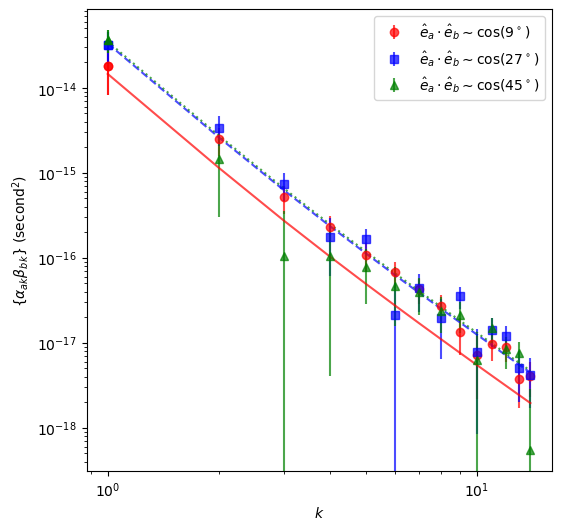

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

na_bins = 10; n_bins=14

angular_bins=[1,2,3]
fmts=['ro', 'bs', 'g^']

for k_index in range(n_bins):
    akak_centers, akak_binned, akak_error = \
        calculate_angular_binned_stats(akak_ensemble, angles_ensemble, k_index, na_bins)
    bkbk_centers, bkbk_binned, bkbk_error = \
        calculate_angular_binned_stats(bkbk_ensemble, angles_ensemble, k_index, na_bins)
    akbk_centers, akbk_binned, akbk_error = \
        calculate_angular_binned_stats(akbk_ensemble, angles_ensemble, k_index, na_bins)
    
    for idx, angular_bin in enumerate(angular_bins):
        ax.errorbar(k_index+1, akbk_binned[angular_bin], yerr=akbk_error[angular_bin], \
                    fmt=fmts[idx], alpha=0.7)     

        if k_index==0:
            ax.errorbar(k_index+1, akbk_binned[angular_bin], yerr=akbk_error[angular_bin], \
                        fmt=fmts[idx], alpha=0.7, \
                        label=rf'$\hat{{e}}_a\cdot \hat{{e}}_b \sim \cos( {int(np.round(akbk_centers[angular_bin]*180/np.pi,0))}^\circ )$')

ax.plot(np.arange(1, n_bins+1), bin_power[9], 'r-', alpha=0.7)
ax.plot(np.arange(1, n_bins+1), bin_power[27], 'b--', alpha=0.7)
ax.plot(np.arange(1, n_bins+1), bin_power[45], 'g:', alpha=0.7)

ax.set_ylabel(rf'$\{{ \alpha_{{ak}} \beta_{{bk}} \}}$ (second$^2$)')

ax.legend(loc='upper right')
ax.set_xlabel(r'$k$')
ax.set_xscale('log'); ax.set_yscale('log')
plt.show()

This can be presented in a dimensionless fashion as well by using the bin power in the isotropic part of the signal for normalization. This is done below;

In [11]:
angles = [9, 27, 45]
bin_power_normalized = {}

for angle in angles:
    xi_ab = angle * np.pi / 180
    bin_power_i = []
    for i in range(n_bins):
        var_Alpha = np.sum(dfgws * TF_Alpha(fgws, i+1, i+1, Tspan) * v00 * psd_gwb_gauss)
        var_Beta = np.sum(dfgws * TF_Beta(fgws, i+1, i+1, Tspan) * v00 * psd_gwb_gauss)
        cov_AlphaBeta = np.sum(dfgws * TF_AlphaBeta(fgws, i+1, i+1, Tspan) * v00 * psd_gwb_gauss)
        bin_power_ab = v00 * cov_AlphaBeta * gammaV11(xi_ab) * np.sqrt(8 * np.pi / 3) * beta * (1 - nv)
        
        bin_power_aa = var_Alpha * gammaI00(xi_ab)
        bin_power_bb = var_Beta * gammaI00(xi_ab)
        
        bin_power_i.append(bin_power_ab/(np.sqrt(bin_power_aa * bin_power_bb)))
    bin_power_normalized[angle] = np.array(bin_power_i)

The simulation results and the theoretical expectation values are shown in the following;

/var/folders/76/cgzytlln5t51nccqwyypn4z40000gp/T/ipykernel_18237/3312291211.py:19: RuntimeWarning: invalid value encountered in sqrt
  nw8=np.sqrt(akak_binned[angular_bin]*bkbk_binned[angular_bin])


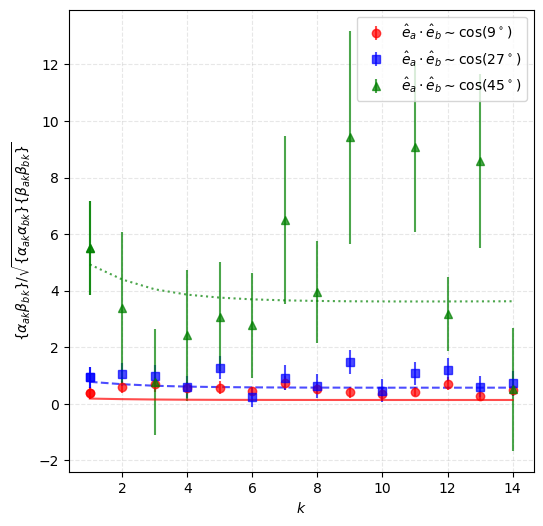

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

na_bins = 10
n_bins=14
npsrs = len(psrs_copy)
angular_bins=[1,2,3]
fmts=['ro', 'bs', 'g^']

for k_index in range(n_bins):
    akak_centers, akak_binned, akak_error = \
        calculate_angular_binned_stats(akak_ensemble, angles_ensemble, k_index, na_bins)
    bkbk_centers, bkbk_binned, bkbk_error = \
        calculate_angular_binned_stats(bkbk_ensemble, angles_ensemble, k_index, na_bins)
    akbk_centers, akbk_binned, akbk_error = \
        calculate_angular_binned_stats(akbk_ensemble, angles_ensemble, k_index, na_bins)
    
    for idx, angular_bin in enumerate(angular_bins):

        nw8=np.sqrt(akak_binned[angular_bin]*bkbk_binned[angular_bin])
        ax.errorbar(k_index+1, \
                    akbk_binned[angular_bin]/nw8, \
                    yerr=akbk_error[angular_bin]/nw8, \
                    fmt=fmts[idx], alpha=0.7)     

        if k_index==0:
            ax.errorbar(k_index+1, \
                        akbk_binned[angular_bin]/nw8, \
                        yerr=akbk_error[angular_bin]/nw8, \
                        fmt=fmts[idx], alpha=0.7, \
                        label=rf'$\hat{{e}}_a\cdot \hat{{e}}_b \sim \cos( {int(np.round(akbk_centers[angular_bin] * 180 / np.pi,0))}^\circ )$')

ax.plot(np.arange(1, n_bins+1), bin_power_normalized[9], 'r-', alpha=0.7)
ax.plot(np.arange(1, n_bins+1), bin_power_normalized[27], 'b--', alpha=0.7)
ax.plot(np.arange(1, n_bins+1), bin_power_normalized[45], 'g:', alpha=0.7)

ax.legend(loc='upper right')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\{ \alpha_{ak} \beta_{bk} \} / \sqrt{ \{ \alpha_{ak} \alpha_{bk} \} \{ \beta_{ak} \beta_{bk} \} }$')
ax.grid(True, which='both', ls='--', alpha=0.3)
plt.show()

End of notebook